# Reproduce Transformer Base Model from Attention is All You Need

## Preliminaries

In [2]:
import os


NUM_PROC = os.cpu_count()
VOCAB_SIZE = 37000
DATASET = "wmt14"
LANG = "de-en"
SOURCE_LANG = "de"
TARGET_LANG = "en"
MAX_SEQ_LEN = 128

## Dataset

The paper used the dataset [WMT2014](https://huggingface.co/datasets/wmt14) English-German dataset consisting of 4.5M sentence pairs. 

In [13]:
from datasets import load_dataset


dataset = load_dataset(DATASET, LANG) # Note: the dataset is downloaded at ~/.cache/huggingface/datasets

In [14]:
def probe_dataset():
    # probe the dataset
    for key in dataset:
        print(f"{key}: {len(dataset[key])} entries")
    # print the first 3 entries of the training set
    for i in range(3):
        print(f"#{i+1}")
        sample = dataset["train"][i]
        for key in sample:
            if key == "translation":
                for lang in sample[key]:
                    print(f"{lang}: {sample[key][lang]}")
            else:
                print(f"{key}: {sample[key]}")

    
probe_dataset()

train: 4508785 entries
validation: 3000 entries
test: 3003 entries
#1
de: Wiederaufnahme der Sitzungsperiode
en: Resumption of the session
#2
de: Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
en: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
#3
de: Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.
en: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.


### Tokenizer

The paper used a byte-pair encoding with a shared (English + German) vocab of 37000 tokens. 

I want to build the tokenizer solely from this dataset. So I avoid using pre-trained tokenizer from HuggingFace.

The following code follows [HuggingFace's tutorial on tokenizers](https://huggingface.co/docs/tokenizers/quicktour) .

Training about 2 mins.

In [5]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace


def batch_iterator(batch_size: int = 100):
    for lang in [SOURCE_LANG, TARGET_LANG]:
        for key in ["train", "validation", "test"]:
            for i in range(0, len(dataset[key]), batch_size):
                yield [item[lang] for item in dataset[key][i:i+batch_size]["translation"]]


saved_tokenizer = f"tokenizer-{DATASET}-{SOURCE_LANG}-{TARGET_LANG}.json"
try:
    tokenizer = Tokenizer.from_file(saved_tokenizer)
except:
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=sum([len(_) for _ in dataset.values()]))
    tokenizer.save(saved_tokenizer)

### Update the dataset with tokens

Takes about 1 mins

In [15]:
def encode(sample):
    encoding_src = tokenizer.encode(sample["translation"][SOURCE_LANG])
    encoding_tgt = tokenizer.encode(sample["translation"][TARGET_LANG])
    return ({
        "input_ids": encoding_src.ids,
        "attention_mask": encoding_src.attention_mask,
        "labels": encoding_tgt.ids,
        "decoder_attention_mask": encoding_tgt.attention_mask,
    })


for key in ["train", "validation", "test"]:
    dataset[key] = dataset[key].map(encode, num_proc=NUM_PROC)
probe_dataset()

train: 4508785 entries
validation: 3000 entries
test: 3003 entries
#1
de: Wiederaufnahme der Sitzungsperiode
en: Resumption of the session
input_ids: [28682, 3784, 27639]
attention_mask: [1, 1, 1]
labels: [5064, 30454, 3792, 3780, 10827]
decoder_attention_mask: [1, 1, 1, 1, 1]
#2
de: Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
en: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
input_ids: [4193, 33340, 3804, 3813, 15961, 16, 3895, 5372, 18, 9212, 18543, 73, 27639, 3880, 4495, 5614, 3877, 4877, 9163, 16, 12849, 4757, 13710, 6130, 20620, 4224, 6950, 9848, 3800, 7569, 16, 4332, 3941, 10821, 8613, 7876, 18]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

### Analyze Sequence Length

In [24]:
# Takes about 6 mins
seq_len = {"input_ids": [], "labels": []}
for item in dataset["train"]:
    seq_len["input_ids"].append(len(item["input_ids"]))
    seq_len["labels"].append(len(item["labels"]))

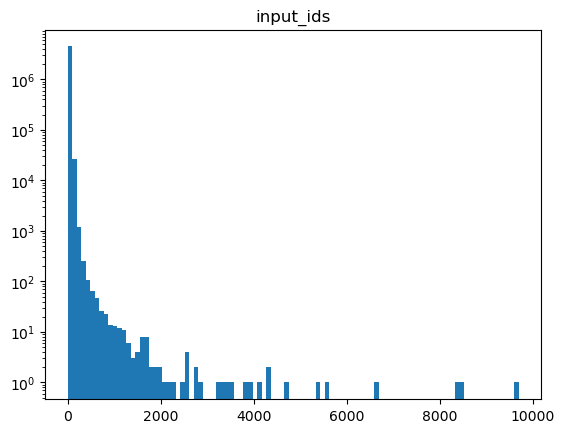

4.2112% of the samples are dropped if truncated at   64 tokens
0.1751% of the samples are dropped if truncated at  128 tokens
0.0189% of the samples are dropped if truncated at  256 tokens
0.0055% of the samples are dropped if truncated at  512 tokens
0.0019% of the samples are dropped if truncated at 1024 tokens
0.0006% of the samples are dropped if truncated at 2048 tokens
0.0002% of the samples are dropped if truncated at 4096 tokens


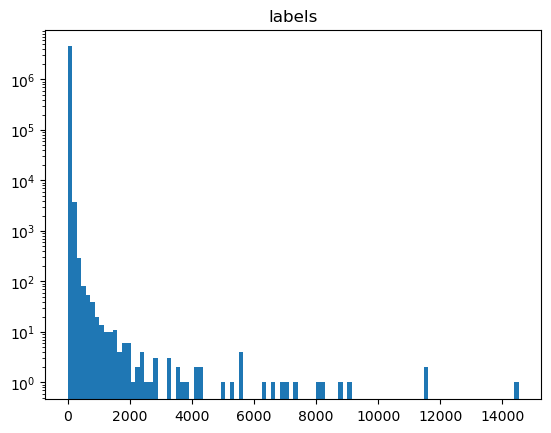

3.9552% of the samples are dropped if truncated at   64 tokens
0.1661% of the samples are dropped if truncated at  128 tokens
0.0175% of the samples are dropped if truncated at  256 tokens
0.0055% of the samples are dropped if truncated at  512 tokens
0.0022% of the samples are dropped if truncated at 1024 tokens
0.0009% of the samples are dropped if truncated at 2048 tokens
0.0005% of the samples are dropped if truncated at 4096 tokens


In [41]:
import numpy as np
import matplotlib.pyplot as plt


for key in seq_len:
    seq_len[key] = np.array(seq_len[key])
    plt.hist(seq_len[key], bins=100, log=True)
    plt.title(key)
    plt.show()
    for exponent in range(6, 13):
        truncate_len = 2 ** exponent
        rate = np.sum(seq_len[key] > truncate_len) / len(seq_len[key])
        print(f"{rate * 100:<6.4f}% of the samples are dropped if truncated at {truncate_len:>4} tokens")

Therefore, during prototyping, I'll use 128 as the max sequence length.

### Reconstruct the dataset with tokens

Takes about 2 mins

In [42]:
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("[PAD]"), pad_token="[PAD]", length=MAX_SEQ_LEN)
tokenizer.enable_truncation(max_length=MAX_SEQ_LEN)
for key in ["train", "validation", "test"]:
    dataset[key] = dataset[key].map(encode, num_proc=NUM_PROC)
probe_dataset()

Map (num_proc=10):   0%|          | 0/4508785 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/3003 [00:00<?, ? examples/s]

train: 4508785 entries
validation: 3000 entries
test: 3003 entries
#1
input_ids: tensor([28682,  3784, 27639,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     

### Create dataloader

In [43]:
import torch


dataloader = {}
for key in ["train", "validation", "test"]:
    dataset[key].set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "decoder_attention_mask"])
    dataloader[key] = torch.utils.data.DataLoader(dataset[key], batch_size=32, shuffle=True)

In [44]:
for batch in dataloader["train"]:
    print(batch)
    break

{'input_ids': tensor([[   13,  4939,  3953,  ...,     3,     3,     3],
        [ 4153, 15997, 19867,  ...,     3,     3,     3],
        [18912,  3941,  3956,  ...,     3,     3,     3],
        ...,
        [31704,  5308,  3784,  ...,     3,     3,     3],
        [ 4290,  9949,  3771,  ...,     3,     3,     3],
        [ 4835,  3784, 16312,  ...,     3,     3,     3]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[   13,  5910,  4368,  ...,     3,     3,     3],
        [   37,  4278, 30199,  ...,     3,     3,     3],
        [ 4935,  4017,  4086,  ...,     3,     3,     3],
        ...,
        [ 4805,  5638,  3976,  ...,     3,     3,     3],
        [ 3775,  3780,  4872,  ...,     3,     3,     3],
        [ 6043, 16312,  3822,  ...,     3,     3,     3]]), 'decoder_atte

## Transformer from Scratch

In [49]:
from torch import nn


class Transformer(nn.Module):
    def __init__(self, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6, num_decoder_layers: int = 6,
                 dim_feedforward: int = 2048, dropout: int = 0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout

# allow adding new methods to a class
def add_method(cls):
    def decorator(func):
        setattr(cls, func.__name__, func)
        return func
    return decorator

### Embedding Layer

The same layer (weights) is used for both the input and output embeddings.

In [48]:
@add_method(Transformer)
def embedding(self, x: torch.Tensor):
    if not hasattr(self, "_embedding"):
        self._embedding = nn.Embedding(tokenizer.get_vocab_size(), self.d_model)
    return self._embedding(x)

### Positional Encoding

In [ ]:
@add_method(Transformer)
def pos_encoding(self, x: torch.Tensor):
    if not hasattr(self, "_pos_encoding"):
        pos = torch.arange(0, x.shape[1], dtype=torch.float32).unsqueeze(0)

### Attention Layer

### Layer Normalization

### MLP Layer

### Encoder

### Decoder

### Build Transformer

In [46]:
@add_method(Transformer)
def forward(self, x: torch.Tensor):
    # x: (batch_size, seq_len)
    x = self.embedding(x) * torch.sqrt(self.d_model) + self.positional_encoding(x)
    # x: (batch_size, seq_len, d_model)
    return x


model = Transformer()

[0.38076211 0.46243897 0.82224138 0.27802744 0.68888738]
[0.38076211 0.46243897 0.82224138 0.27802744 0.68888738]


## Train

## Test